In [11]:
import os
import pathlib
import sys
from dataclasses import asdict, replace
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import datetime

import matplotlib.pyplot as plt
import netket as nk
import pandas as pd
from omegaconf import OmegaConf
from hydra.utils import instantiate
from hydra import compose, initialize_config_dir

project_path = pathlib.Path(os.getcwd()).parent
sys.path.append(project_path.as_posix())

from src.utils import report_name, report_path, report_name_with_data
from src.result.struct import Result
from src.model.struct import get_type

In [12]:
HYDRA_PATH = os.path.join(project_path, "outputs")
HYDRA_START_DATE = "2025-11-13"
HYDRA_END_DATE = "2025-11-20"

RESULT_PATH = "../data/result"
CONFIG_PATH = "../config"

In [13]:
os.makedirs(RESULT_PATH, exist_ok=True)

In [14]:
cfg = OmegaConf.load(f"{CONFIG_PATH}/config.yaml")

In [15]:
def load_all_hydra_configs(base_dir):
    base_path = pathlib.Path(base_dir)
    configs = []

    hydra_dirs = base_path.glob("*/*/.hydra")

    for hydra_dir in hydra_dirs:
        try:
            # Извлекаем дату и время из пути
            path_parts = hydra_dir.parent.parts
            if len(path_parts) >= 2:
                date_str = path_parts[-2]  # дата (например, "2024-01-15")
                time_str = path_parts[-1]  # время (например, "10-30-45")

                # Парсим в datetime объект
                try:
                    dt = datetime.datetime.strptime(
                        f"{date_str} {time_str}", "%Y-%m-%d %H-%M-%S"
                    )
                except ValueError:
                    # Если формат не совпадает, используем текущее время
                    dt = datetime.datetime.now()
            else:
                date_str = "unknown"
                time_str = "unknown"
                dt = datetime.datetime.now()

            with initialize_config_dir(config_dir=str(hydra_dir), version_base=None):
                cfg = compose(config_name="config")
                configs.append(
                    {
                        "path": str(hydra_dir.parent),
                        "config": cfg,
                        "date": date_str,
                        "time": time_str,
                        "datetime": dt,
                        "timestamp": dt.timestamp(),  # для удобной сортировки
                    }
                )
        except Exception as e:
            print(f"Ошибка загрузки конфига из {hydra_dir}: {str(e)}")

    return configs


def filter_by_date_range(configs, start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    return [exp for exp in configs if start_dt <= exp["datetime"] <= end_dt]

In [16]:
def plot_character(data: pd.DataFrame, chain_cfg, report_path: str):
    hilbert = nk.hilbert.Spin(N=chain_cfg.n, s=chain_cfg.spin)

    h = data["h"]
    e = []
    for curr_h in h:
        chain_cfg = replace(chain_cfg, h=curr_h)
        en = Result.analytical_energy(chain_cfg, hilbert, order=0)
        e.append(en / chain_cfg.n)

    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
    suptitle = "Характеристики в зависимости от h"
    fig.suptitle(suptitle)

    ax[0].set(xlabel=r"$h$", ylabel=r"$\frac{E}{n}$")
    ax[0].scatter(h, e)
    ax[0].scatter(h, data["estimated_e"] / chain_cfg.n)

    ax[1].set(xlabel=r"$h$", ylabel=r"$\langle \hat{S}_i^x \hat{S}_{i+1}^x \rangle$")
    ax[1].scatter(h, data["estimated_xx"])

    ax[2].set(xlabel=r"$h$", ylabel=r"$\langle \hat{S}_i^y \hat{S}_{i+1}^y \rangle$")
    ax[2].scatter(h, data["estimated_yy"])

    ax[3].set(xlabel=r"$h$", ylabel=r"$\langle \hat{S}_i^z \hat{S}_{i+1}^z \rangle$")
    ax[3].scatter(h, data["estimated_zz"])

    plt.savefig(
        f"{report_path}/energy_correlations_plot.png", dpi=300, bbox_inches="tight"
    )

In [17]:
def find_matching_runs(pattern):
    runs_dir = "../runs"
    if not os.path.exists(runs_dir):
        runs_dir = "../../runs"
        if not os.path.exists(runs_dir):
            print(f"Директория {runs_dir} не найдена!")
            return []

    all_runs = os.listdir(runs_dir)
    matching_runs = []

    for run_name in all_runs:
        run_path = os.path.join(runs_dir, run_name)
        if os.path.isdir(run_path) and pattern in run_name:
            matching_runs.append(run_path)

    return matching_runs


def load_scalar_data(run_path, scalar_tag):
    try:
        event_files = [f for f in os.listdir(run_path) if f.startswith("events")]
        if not event_files:
            print(f"Не найдено event файлов в {run_path}")
            return None, None

        event_file_path = os.path.join(run_path, event_files[0])
        event_acc = EventAccumulator(event_file_path)
        event_acc.Reload()

        if scalar_tag in event_acc.Tags()["scalars"]:
            scalar_data = event_acc.Scalars(scalar_tag)
            steps = [event.step for event in scalar_data]
            values = [event.value for event in scalar_data]
            return steps, values
        else:
            print(f"Скаляр {scalar_tag} не найден в {run_path}")
            return None, None
    except Exception as e:
        print(f"Ошибка при загрузке {run_path}: {e}")
        return None, None

In [18]:
def plot_runs(cfg, data: pd.DataFrame, report_path: str, batch_size: int = 5):
    h = data["h"]
    scalars = ['Energy/Mean/re', 'Energy/Mean/im', 'Energy/Variance', 'Energy/Sigma', 'Energy/R_hat', 'Energy/TauCorr']

    h_batches = [h[i : i + batch_size] for i in range(0, len(h), batch_size)]

    num_batches = len(h_batches)
    
    # Создаем фигуру с подграфиками для каждого батча и каждого скаляра
    fig, axes = plt.subplots(num_batches, len(scalars), figsize=(6 * len(scalars), 6 * num_batches))
    
    # Если только один батч, преобразуем axes в 2D массив для единообразия
    if num_batches == 1:
        axes = [axes]
    
    # Если только один скаляр, преобразуем axes в правильную форму
    if len(scalars) == 1:
        axes = [[ax] for ax in axes]

    for batch_idx, (h_batch, ax_row) in enumerate(zip(h_batches, axes)):
        for curr_h in h_batch:
            pattern = report_name_with_data(cfg, f"{curr_h:.5f}")
            run_paths = find_matching_runs(pattern)

            if not run_paths:
                print(f"Не найдено runs для h={curr_h} с pattern: {pattern}")
                continue

            for run_path in run_paths:
                for scalar_idx, scalar in enumerate(scalars):
                    ax = ax_row[scalar_idx]
                    steps, values = load_scalar_data(run_path, scalar)
                    
                    if steps and values:
                        run_name = os.path.basename(run_path)
                        ax.plot(steps, values, label=f"h={curr_h:.5f}", linewidth=2)
                        ax.plot(steps[-1], values[-1], "o", markersize=8)

        # Настройка подграфиков для текущего батча
        for scalar_idx, (scalar, ax) in enumerate(zip(scalars, ax_row)):
            ax.set_xlabel("Step")
            ax.set_ylabel(scalar)
            ax.set_title(f"{scalar} для h = {h_batch}")
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{report_path}/training_curves_plot.png", dpi=300, bbox_inches="tight")
    plt.close()  # Закрываем фигуру чтобы освободить память

In [19]:
all_configs = load_all_hydra_configs(HYDRA_PATH)

all_configs.sort(key=lambda x: x["timestamp"], reverse=True)

filtered_configs = filter_by_date_range(all_configs, HYDRA_START_DATE, HYDRA_END_DATE)

Генерируем отчет для эксперимента /home/merkul/Project/XYZModelNQS/project/outputs/2025-11-14/20-36-48


/tmp/ipykernel_538160/3082999272.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  h_batches = [h[i : i + batch_size] for i in range(0, len(h), batch_size)]


KeyboardInterrupt: 

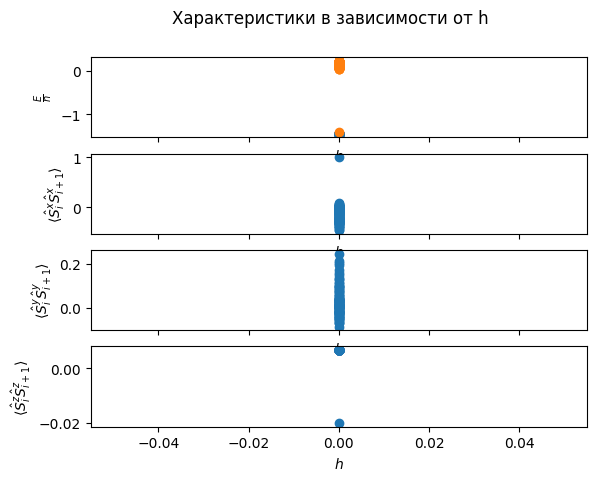

In [ ]:
for exp in filtered_configs:
    exp_hash = report_name(exp["config"])
    report_data = report_path(cfg=exp["config"], path_data=cfg.path_data)
    REPORT_PATH = f"{RESULT_PATH}/{exp_hash}"

    chain_cfg = instantiate(exp["config"]["chain"])

    report_content = f"""
## Отчет по эксперименту

### Методология

**Используемый гамильтониан**

![Гамильтониан](../../../docs/hamiltonian.png)

### Параметры эксперимента

| Параметр | Значение |
|----------|-----------|
| Путь к данным | `{exp['path']}` |
| Хэш эксперимента | `{exp_hash}` |
| Дата | {exp['date']} |
| Время | {exp['time']} |
| Полная дата-время | {exp['datetime'].strftime('%Y-%m-%d %H:%M:%S')} |
| Обработанные данные | {report_data} |

### Конфигурация эксперимента

```yaml
{OmegaConf.to_yaml(exp['config'])}
```

Спиновая цепочка: {get_type(chain_cfg)}

## Визуализация результатов

### Зависимости от параметра h

![Энергия и корреляции](energy_correlations_plot.png)

*Рисунок 1: Зависимость энергии и корреляционных функций от внешнего поля h*

### Процесс обучения

![Обучение модели](training_curves_plot.png)

*Рисунок 2: Кривые обучения для различных значений параметра h*
"""

    if not os.path.exists(report_data):
        print(f"Для эксперимента {exp['path']} нет данных")
        print(f"Хэш: {exp_hash}")
        print(f"Данные: {report_data}")
        print(f"Дата: {exp['date']}")
        print(f"Время: {exp['time']}")
        print(f"Полная дата-время: {exp['datetime'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(OmegaConf.to_yaml(exp["config"]))
        print("-" * 50)
        continue

    os.makedirs(REPORT_PATH, exist_ok=True)

    print(f"Генерируем отчет для эксперимента {exp['path']}")

    data = pd.read_csv(report_data, delimiter=",")

    if len(data) == 0:
        print("В данных нет записей")
        continue

    plot_character(data=data, chain_cfg=chain_cfg, report_path=REPORT_PATH)

    plot_runs(cfg=exp["config"], data=data, report_path=REPORT_PATH)

    with open(f"{REPORT_PATH}/report.md", "w", encoding="utf-8") as f:
        f.write(report_content)